<a href="https://colab.research.google.com/github/taimur1871/cycle_gan_tutorial/blob/main/Rana_MLE_Perception_Engineer_Uber_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Today you are a MLE at Uber Perception Stack Team!**
## Your team is developing new software around automated detection of cars, pedestrians at all conditions for autonomous drive. One major bottleneck is data collection under severe weather conditions, especially capturing night-time images. So your task is to generate night time equivalent images from daytime images, such that you have access to some outdoor images acquired at night and some at day, but no pairwise images are available.

### *Pairwise image means*: same view available in Day and Night times.


In this assignment we implement CycleGAN using Keras with the intention to transform Day time to night time images for Autonomous Drive like in:
https://github.com/simontomaskarlsson/CycleGAN-Keras

This work is an adaptation of the blog in: https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

#Lets start with the concepts of CycleGAN:

The model architecture is comprised of two generator models: one generator (Generator-A) for generating images for the first domain (Domain-A) and the second generator (Generator-B) for generating images for the second domain (Domain-B). Lets consider here, **Domain-A: Daytime**, **Domain-B: Nighttime**

* Generator-A -> Domain-A
* Generator-B -> Domain-B

The generator models perform image translation, meaning that the image generation process is conditional on an input image, specifically an image from the other domain. Generator-A takes an image from Domain-B as input and Generator-B takes an image from Domain-A as input.

* Domain-B -> Generator-A -> Domain-A
* Domain-A -> Generator-B -> Domain-B
Each generator has a corresponding discriminator model.

The first discriminator model (Discriminator-A) takes real images from Domain-A (daytime images) and generated images from Generator-A and predicts whether they are real or fake. The second discriminator model (Discriminator-B) takes real images from Domain-B (night-time images) and generated images from Generator-B and predicts whether they are real or fake.

* Domain-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Discriminator-B -> [Real/Fake]
* Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]
The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models.

The generators learn to better fool the discriminators and the discriminators learn to better detect fake images. Together, the models find an equilibrium during the training process.

Passing an image through both generators is called a cycle. Together, each pair of generator models are trained to better reproduce the original source image, referred to as cycle consistency.

* Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
* Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A


**Our goal is to train such a 2 set Generator-Discriminator pair, to finally generate night-time images from day-time ones and quantify performance...**



# Task 0: Install libraries and load data

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 8.0MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
import os
# The path below should point to the directory containing this notebook
# and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/4BAI/Week 9/training')
!ls

day  discriminator_model_plot.png  generator_model_plot.png  night


## **Task 1 [Instructor Led]:  Design functions for Generator-Discriminator pairs**: 


Step 1: Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [5]:
#Step 1: Defining a Patchgan discriminator model
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from random import randint

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', 
            kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d) #Stride reduces shape of image
	# C128
	d = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5),
               loss_weights=[0.5])
	return model

In [7]:
# Summarize and visualize model
# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png',
           show_shapes=True,
           show_layer_names=True)
######### Note the final shape of the image patch=Patch size ############

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 128)     131200    
_________________________________________________________________
instance_normalization_4 (In (None, 128, 128, 128)     256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 256)     5245

In [8]:
#Step 2: Generator Model
# generate a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', 
            kernel_initializer=init)(input_layer)
	g = InstanceNormalization()(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization()(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [9]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=9):
	# weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=image_shape)
  # c7s1-64
  g = Conv2D(64, (7,7), padding='same', 
             kernel_initializer=init)(in_image)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # d128
  g = Conv2D(128, (3,3), strides=(2,2), padding='same', 
             kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # d256
  g = Conv2D(256, (3,3), strides=(2,2), padding='same',
             kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # R256
  for _ in range(n_resnet):
    g = resnet_block(256, g)
  # u128
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same',
                      kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # u64
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same',
                      kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # c7s1-3
  g = Conv2D(3, (7,7), padding='same', 
             kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  out_image = Activation('sigmoid')(g)
  # define model
  model = Model(in_image, out_image)
  return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
instance_normalization_8 (Insta (None, 256, 256, 64) 128         conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_8[0][0]   
____________________________________________________________________________________________

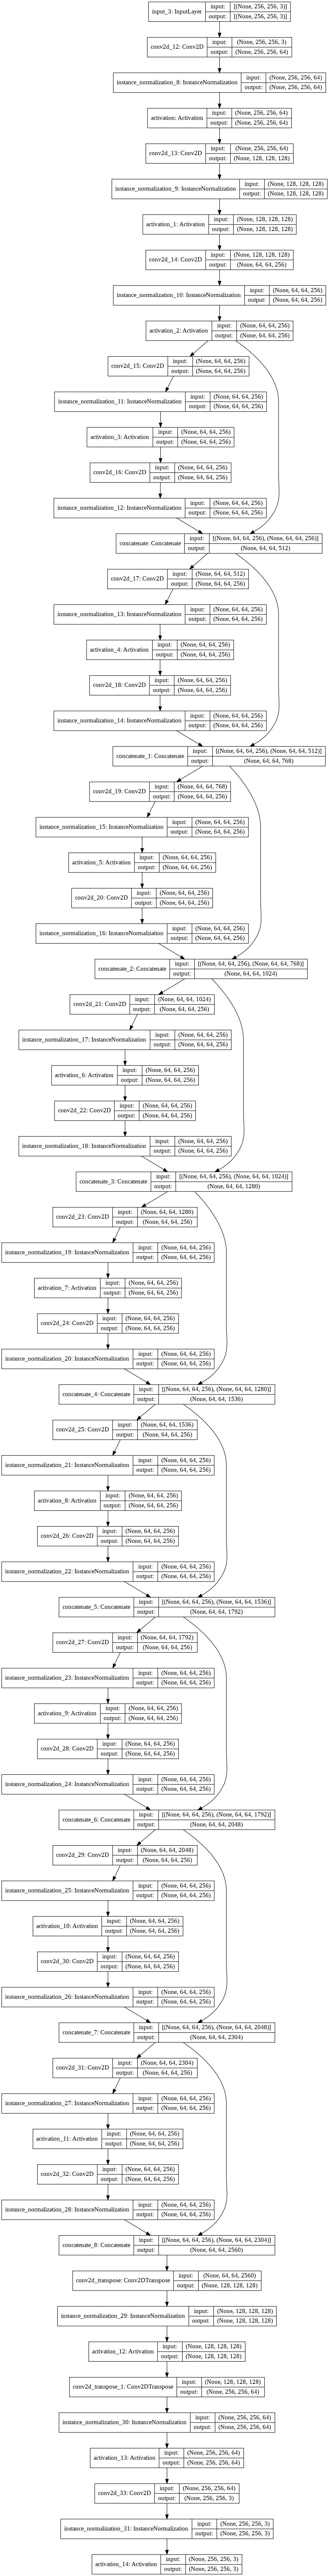

In [10]:
# create the model
model = define_generator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', 
           show_shapes=True, 
           show_layer_names=True)

In [11]:
# Step 3: Define a composite model for updating generators
# by adversarial and cycle loss
def define_composite_model(g_model_1,
                           d_model, 
                           g_model_2,
                           image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], 
               [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], 
               optimizer=opt)
	return model
  ############ Notice no cross enytropy loss used here#################

In [12]:
#Step 4: All definitions together
# input shape
image_shape = (256,256,3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, 
                                      g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, 
                                      g_model_AtoB, image_shape)

In [13]:
#Step 5: Helper functions to select real samples and generate fake samples

# write a function to generate 'n_samples' 
# random integers in range (start,stop)
def randnums(start,stop,n_samples):
  ix=[]
  for i in range(n_samples):
    ix.append(randint(start,stop))
  ix=np.array(ix)
  return ix

In [14]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
# choose random instances
  ix = randnums(0, dataset.shape[0]-1, n_samples)
  # retrieve selected images
  #print(ix,np.shape(dataset))
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return X, y

In [15]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [16]:
# update image pool for fake images
import random
def update_image_pool(pool, images, max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
    # stock the pool
      pool.append(image)
      selected.append(image)
    elif random.random() < 0.5:
      # use image, but don't add it to the pool
      selected.append(image)
    else:
      # replace an existing image and use replaced image
      ix = randint(0, len(pool)-1)
      print(ix,np.shape(pool))
      selected.append(pool[ix])
      pool[ix] = image
  return np.asarray(selected)

# All helper functions are now defined, now lets begin training!

Order of tasks:
* Update Generator-B (A->B)
* Update Discriminator-B
* Update Generator-A (B->A)
* Update Discriminator-A

In [77]:
# train function for the cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA,
          c_model_AtoB, c_model_BtoA, trainA,trainB):

  # define properties of the training run
  # Keep n_batch as 1 for per image training. n_epochs can be changed
  n_epochs, n_batch, = 10, 1
  # determine the output square shape of the discriminator
  # Notice n_patch depends on the discriminator output image size.
  # This parameter can be changed for improvement.
  n_patch = d_model_A.output_shape[1]
  #n_patch = 32
  
  # prepare image pool for fakes
  poolA, poolB = list(), list()
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  print(n_steps)
  for i in range(n_steps):
  # select a batch of real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    
    # generate a batch of fake samples
    X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA,
                                             X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, 
                                             X_realA, n_patch)
    # update fakes from pool
    X_fakeA = update_image_pool(poolA, X_fakeA)
    X_fakeB = update_image_pool(poolB, X_fakeB)
    # update generator B->A via adversarial and cycle loss
    g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA],
                                                      [y_realA, X_realA, 
                                                       X_realB, X_realA])
    # update discriminator for A -> [real/fake]
    dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
    dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
    # update generator A->B via adversarial and cycle loss
    g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], 
                                                      [y_realB, X_realB, 
                                                       X_realA, X_realB])
    # update discriminator for B -> [real/fake]
    dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
    dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
    # summarize performance
    print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % 
          (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
  return (g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA)

# **Task 2: Train the model from scratch** 
# Load the images DomainA-> Day, DomainB-> Night. 
You may use as many as 50 images to train the generator. More images will need more epochs and more train time. So limit training images to 30-50 images from each domain.
# Call the train function to train on the images


In [78]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
from PIL import Image

from tensorflow.keras.preprocessing import image
import cv2

In [40]:
# function to load images as np arrays
def load_img(img_path):
  im_temp = Image.open(img_path)
  im_temp = np.array(im_temp)
  im_temp = np.true_divide(im_temp, 255.0)
  im1 = cv2.resize(im_temp, (256,256))
  return im1

In [41]:
# load daytime images as trainA, 
# nighttime images as train B
# load as numpy array
############START CODE HERE#################################
trainA = np.array([load_img(os.path.join('day', i)) for
                   i in os.listdir('day')[:50]])
trainB = np.array([load_img(os.path.join('night', i)) for 
                   i in os.listdir('night')[:50]])
############################################################

# Next train the cycleGAN using the train function!

In [79]:
# train CycleGAN
############START CODE HERE##############################
# Call the function 
#train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, 
        # c_model_AtoB, c_model_BtoA,trainA,trainB)
# and save the returned model
gen_a2b, gen_b2a, c_a2b, c_b2a = train(d_model_A, d_model_B,
                                       g_model_AtoB, g_model_BtoA,
                                       c_model_AtoB, c_model_BtoA,
                                       trainA, trainB)
########################################################

500
>1, dA[0.171,0.181] dB[0.037,0.040] g[8.051,6.317]
>2, dA[0.284,0.190] dB[0.036,0.038] g[8.723,6.666]
>3, dA[0.141,0.179] dB[0.201,0.337] g[3.213,2.933]
>4, dA[0.309,0.175] dB[0.121,0.079] g[5.686,4.961]
>5, dA[0.109,0.151] dB[0.225,0.117] g[4.361,4.088]
>6, dA[0.098,0.092] dB[0.020,0.114] g[8.582,7.113]
>7, dA[0.322,0.183] dB[0.008,0.082] g[4.901,4.809]
>8, dA[0.145,0.210] dB[0.145,0.069] g[3.389,2.624]
>9, dA[0.215,0.192] dB[0.008,0.031] g[6.719,5.708]
>10, dA[0.139,0.201] dB[0.126,0.033] g[3.380,2.563]
>11, dA[0.206,0.126] dB[0.037,0.026] g[6.098,5.145]
>12, dA[0.119,0.148] dB[0.053,0.012] g[7.704,5.531]
>13, dA[0.140,0.162] dB[0.039,0.043] g[7.944,5.844]
>14, dA[0.141,0.108] dB[0.004,0.052] g[7.508,6.451]
>15, dA[0.205,0.121] dB[0.077,0.039] g[6.756,5.202]
>16, dA[0.099,0.168] dB[0.041,0.065] g[3.364,3.029]
>17, dA[0.215,0.192] dB[0.453,0.179] g[3.991,3.447]
>18, dA[0.122,0.160] dB[0.026,0.068] g[7.134,6.557]
>19, dA[0.173,0.146] dB[0.032,0.018] g[7.181,5.421]
>20, dA[0.213,0.1

# **Task 3**: Write a test function to generate fake images for the test set
### Create Day->Night, Night->Day. versions separately
### Visualize some images. What parameters would you change to improve?
Hint: Use the format of the train function to create the test function.

In [80]:
#Define a test function to generate day to night images
import matplotlib.pyplot as plt
def test(g_model_AtoB, g_model_BtoA, 
         c_model_AtoB, c_model_BtoA,
         trainA, trainB):
###################START CODE HERE#############################
  X_realA, _ = generate_real_samples(trainA, 1, 16)
  X_fakeA, _ = generate_fake_samples(g_model_AtoB, X_realA, 16)
  
  X_realB, _ = generate_real_samples(trainB, 1, 16)
  X_fakeB, _ = generate_fake_samples(g_model_BtoA, X_realB, 16)
###############################################################    
    ########First Day to night transformation
  print('Original Day Image is=\n')
  plt.imshow(np.squeeze(X_realA))
  plt.show()
  print('Fake Night image is=\n')
  plt.imshow(np.squeeze(X_fakeA))
  plt.show()
  #############Next Night to Day transformation
  print('Original Night Image is=\n')
  plt.imshow(np.squeeze(X_realB))
  plt.show()
  print('Fake Day image is=\n')
  plt.imshow(np.squeeze(X_fakeB))
  plt.show()

Original Day Image is=



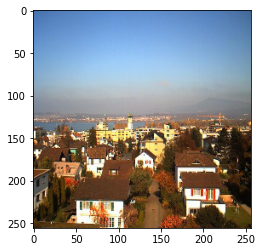

Fake Night image is=



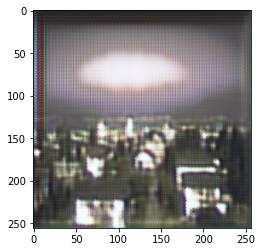

Original Night Image is=



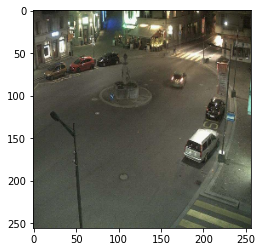

Fake Day image is=



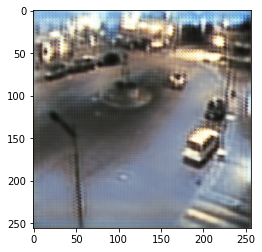

In [81]:
##Call the test function here test(.....)
#########START CODE HERE###############################
test(gen_a2b, gen_b2a, 
     c_model_AtoB, c_model_BtoA,
     trainA, trainB)
########################################################

 # Notice a Banding around edges for the nighttime images. What paremeter would you change to reduce this banding?

 I think that changing the discriminator patch size might help reduce this banding. Specifically increasing the field of view of the patches which might result in the discriminator learning more information. That in turn would give a positive feedback and force generator to make better 'fake' images.

# **Task 4**: Write a function to generate a full cycle Day->night->Day
[Hint]: Use the template in the train function to start with Day image and plot the cyclic day image generated.

# Write a function to quantify the error and similarity between the cycle generated image and original image (Day vs Generated Day)
[Hint]: Find mse and structural similarity between real and fake images to gauge the quality of cycleGAN.



In [58]:
#Function to compute similarity in Cycle images
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def similarity_real_fake(real,fake):
  ###################Start Code Here##############################
  mse_cycle = mean_squared_error(real, fake)
  ssim_cycle = ssim(real, fake, multichannel=True, 
                    gaussian_weights=True, sigma=1.5)
  print('MSE= ', mse_cycle)
  print('SSIM= ', ssim_cycle)
  ################################################################

In [73]:
def test_Cycle(g_model_AtoB, g_model_BtoA, c_model_AtoB,
               c_model_BtoA, trainA,trainB):

  # write this function to call the similarity_real_fake function above 
  # and print it under each real->Generated image pair
  ##############START CODE HERE######################################
  # define training parameters
  n_epochs, n_batch = 1, 1

  # set the patch size for discriminator
  n_patch = 32

  n_steps = 50

  for i in range(n_steps):
    # get real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

    # generate fake samples
    X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

    # get fake/real samples
    X_fakeAA, y_fakeAA = generate_fake_samples(g_model_BtoA, X_fakeB, n_patch)
    X_fakeBB, y_fakeBB = generate_fake_samples(g_model_AtoB, X_fakeA, n_patch)
  ###################################################################
  # day to night transform
  realA = np.squeeze(X_realA)
  fakeA = np.squeeze(X_fakeAA)
  print('Original Day Image: \n')
  plt.imshow(realA)
  plt.show()
  print('Fake Day Image: \n')
  plt.imshow(fakeA)
  plt.show()

  similarity_real_fake(realA, fakeA)

  # night to day transform
  realB = np.squeeze(X_realB)
  fakeB = np.squeeze(X_fakeBB)
  print('Orginal Night Image: \n')
  plt.imshow(realB)
  plt.show()
  print('Fake Night Image: \n')
  plt.imshow(fakeB)
  plt.show()

  similarity_real_fake(realB, fakeB)

Original Day Image: 



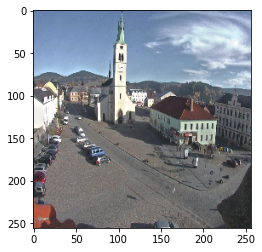

Fake Day Image: 



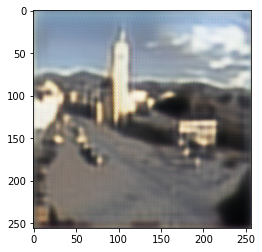

MSE=  0.010374131174100664
SSIM=  0.6563230998131981
Orginal Night Image: 



/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


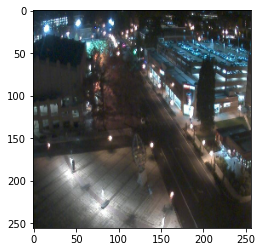

Fake Night Image: 



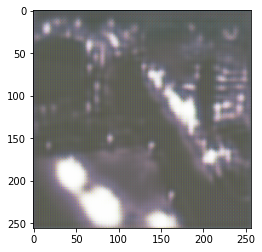

MSE=  0.041950696955919575
SSIM=  0.5451213265463123


In [74]:
# Call the function test_Cycle(....)
test_Cycle(gen_a2b, gen_b2a, 
           c_model_AtoB, c_model_BtoA,
           trainA, trainB)

# Comment on which domain transformation is better quality and some steps to improve performance.

I tried changing the n_patch and n_steps, overall the day to day transformation seems to do better than night to night. Also increasing patch size to 64 did not give signficantly better results than patch size of 32.

To improve performance I would train on the full dataset or at least train on the full night dataset. It seems like the features on night pictures are harder to learn which leads to worse outcomes for that domain.

